<a href="https://colab.research.google.com/github/DenizY98/pydemo/blob/main/Fallstudie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prozessoptimierung - Fallstudie

##PIP, OR-Tools und Pandas

In [ ]:
# Importieren der benötigten Bibliotheken
!pip install -U -q pip
!pip install -q ortools
# Laden des Programms
from ortools.linear_solver import pywraplp
import pandas as pd
# Initialisieren des Solvers
solver = pywraplp.Solver.CreateSolver('SCIP')

In [ ]:
! git clone https://github.com/AlexKressner/Industrielles_Management

fatal: destination path 'Industrielles_Management' already exists and is not an empty directory.


In [ ]:
path = "Industrielles_Management/Daten/Fallstudie/"

In [ ]:
#dataframes laden aus Daten der CSV-Dateien
nachfrage_df = pd.read_csv(f"{path}/FLINK_Nachfrage.csv", sep=";", index_col=0) # Da Indizes in Datenquelle so festgelegt
standorte_df = pd.read_csv(f"{path}/FLINK_Standorte.csv", sep=";")

##Ziel:
Maximierung der bedienten Nachfrage innerhalb der vorgegebenen Lieferzeit und des Budgets.


##Daten:


###Indexmengen:
$ Q = \{q \mid q = (i,j), i \in \{0, \ldots, 12\}, j \in \{0, \ldots, 12\}\} $
Menge aller Quadranten $ q $ als $( i , j )$ Tupel


$ S = \{s \mid s \in \{0, \ldots, 9\}\} $
Menge aller potentieller DarkStores $ s $

In [ ]:
Q = [(i, j) for i in range(nachfrage_df.shape[0]) for j in range(nachfrage_df.shape[1])]  # Menge aller Quadranten als (i, j) Paare
S = standorte_df['Potenzielle_Standorte'].to_list()  # Menge aller potentieller DarkStores

###Variablen:
$ x_s \in \{0,1\} \quad \forall s \in S $: Binärvariable, die angibt, ob am Standort $ s $ ein Dark Store eingerichtet wird $1$ oder nicht $0$.

$ y_{qs} \in \{0,1\} \quad \forall q \in Q, \forall s \in S $: Binärvariable, die angibt, ob der Standort $ s $ den Quadranten $ q (i,j) $ bedient $1$ oder nicht $0$.

In [ ]:
x = {}
for s in S:
  x[s] = solver.BoolVar(f'x[{s}]')

In [ ]:
y = {}
for s in S:
    for q in Q:
        y[q, s] = solver.BoolVar(f'y[{q},{s}]')

###Dictionaries:
- Lagerumschlagsleistung je potentiellem Standort $ s $
- Errichtungskosten je potentiellem Standort $ s $
- Koordinaten je potentiellem Standort $ s $

In [ ]:
#Standorte Dataframe
Lagerumschlagleistung = standorte_df.set_index('Potenzielle_Standorte')['Lagerumschlagleistung'].to_dict()
Errichtungskosten = standorte_df.set_index('Potenzielle_Standorte')['Errichtungskosten'].to_dict()
Koordinaten = standorte_df.set_index('Potenzielle_Standorte')[['i_Koordinate','j_Koordinate']].to_dict('index')

###Parameter:

$ D_q $: Nachfrage im Quadranten $ q $ als Bestellungen pro Tag.

$ L_s $: Lagerumschlagleistung des Standorts $ s $ als Bestellungen pro Tag.

$ C_s $: Kosten für die Einrichtung eines Dark Stores am Standort $ s $.

$ B $: Gesamtbudget für die Einrichtung von Dark Stores $1.000.000$.

$ T $: Maximale Lieferzeit $10 Minuten$.

$ TV $: Verbleibende Lieferzeit abzüglich Zeitfresser $TF1$ und $TF2$

$TF1= 3 Minuten$ und $TF2 = 1 Minute$

$ A $: Maximale Distanz, je Fahrradkurier $5 Quadranten$.


In [ ]:
D = {q: nachfrage_df.iat[q[0],q[1]] for q in Q} # Nachfrage im Quadranten q als Bestellungen pro Tag
L = {s: Lagerumschlagleistung[s] for s in S}  # Lagerumschlagleistung des Standorts s als Bestellungen pro Tag
C = {s: Errichtungskosten[s] for s in S}  # Kosten für die Einrichtung eines Dark Stores am Standort s
B = 1000000  # Gesamtbudget für die Einrichtung von Dark Stores
G = 25  # Geschwindigkeit in KM/H
T = 10  # Maximale Lieferzeit 10 Minuten
TF1= 3  # Zeitfresser in Minuten Warenbereitstellung AE
TF2= 1  # Zeitfresser in Minuten Warenübergabe beim Kunden
TV= (T-TF1-TF2) # Verbleibende Zeit abzüglich Zeitfressern
A = round((TV/2)/0.25*G/60, None) # max Reichweite in Quadranten für eine Richtung

###Restriktionen:
####Budgetrestriktion:
$ \sum_{s \in S} x_s \cdot C_s \leq B $

Ein Dark Store kann nur eingerichtet werden, wenn das Budget dies zulässt
####Nachfragerestriktionen:
$ \sum_{s \in S} y_{qs} \leq 1 \quad \forall q \in Q $

Jeder Quadrant wird von höchstens einem Dark Store bedient
####Lagerumschlagleistungsrestriktionen:
$ \sum_{q \in Q} y_{qs} \cdot D_{q} \leq x_s \cdot L_s \quad \forall s \in S $

Die Nachfrage eines Quadranten kann nur bedient werden, wenn die Lagerumschlagleistung ausreicht und ein Dark Store vorhanden ist
####Reichweitenrestriktion:
$ \text{MD}(s, q) > A \Rightarrow y_{qs} = 0 \: \: \: \forall q \in Q, \forall s \in S $

Die Anzahl der von einem Fahrradkurier zurückgelegten Quadranten $Strecke$ darf nie größer $A$ sein, falls bestätigt, dass Quadrant $q$ von Standort $s$ beliefert wird.

In [ ]:
# Nachfragerestriktionen
for q in Q:
    solver.Add(solver.Sum([y[q, s] for s in S]) <= 1)

# Budgetrestriktion
solver.Add(solver.Sum([x[s] * C[s] for s in S]) <= B)

#Lagerumschlagleistungsrestriktionen
for s in S:
    solver.Add(solver.Sum([y[q, s] * D[q] for q in Q]) <= x[s] * L[s])
# Reichweitenrestriktion für Fahrradkuriere
for s in S:
    for q in Q:
        # Berechnung der Manhattan-Distanz zwischen dem Standort s und dem Quadranten q
        distance = abs(Koordinaten[s]['i_Koordinate'] - q[0]) + abs(Koordinaten[s]['j_Koordinate'] - q[1])
        if distance > A:
            solver.Add(y[q, s] == 0)


##Lösung:
###Zielfunktion:
Maximiere die gesamte bediente Nachfrage:

$ \text{Max} \sum_{sq} y_{qs} \cdot D_q $

In [ ]:
# Zielfunktion
solver.Maximize(solver.Sum([y[q, s] * D[q] for q in Q for s in S]))
# Lösen des Modells
status = solver.Solve()

In [ ]:
# Ausgabe der Lösung
if status == pywraplp.Solver.OPTIMAL:
    print('Lösung gefunden:')
    for s in S:
        if x[s].solution_value() == 1:
            print(f'Standort {s} wird eingerichtet.')
            bedient=[]
            bedient=[q for q in Q if y[q, s].solution_value() > 0]
            print(f'und bediente {", ".join(f"({q[0]}/{q[1]})" for q in bedient)}')
            # for q in Q:
else:
    print('Keine optimale Lösung gefunden.')

Lösung gefunden:
Standort 1 wird eingerichtet.
und bediente (6/12), (7/11), (7/12), (8/12), (9/8), (9/10), (9/11), (9/12), (10/10), (11/11), (12/10)
Standort 2 wird eingerichtet.
und bediente (8/1), (9/0), (9/1), (9/2), (9/3), (10/0), (10/1), (10/2), (11/0), (11/1), (11/2), (11/3), (12/1)
Standort 3 wird eingerichtet.
und bediente (6/10), (7/9), (7/10), (8/10), (9/9), (10/5), (10/6), (10/9), (10/11), (10/12), (11/7), (11/9), (11/10), (11/12), (12/11), (12/12)
Standort 4 wird eingerichtet.
und bediente (9/5), (9/7), (10/4), (10/7), (10/8), (11/4), (11/5), (11/6), (12/2), (12/3), (12/4), (12/5), (12/6), (12/7), (12/8), (12/9)
Standort 5 wird eingerichtet.
und bediente (0/8), (1/9), (1/10), (2/10), (2/11), (3/11), (3/12), (4/12), (5/11), (5/12), (6/11), (8/8), (8/9)
Standort 7 wird eingerichtet.
und bediente (0/6), (0/7), (1/7), (1/8), (2/5), (2/8), (2/9), (3/5), (3/7), (3/9), (3/10), (4/1), (4/4), (4/10), (4/11), (5/5), (5/6), (5/7), (5/8), (5/9), (5/10), (6/4), (6/5), (6/6), (6/8), (6/9

In [ ]:
print('Zielfunktionswert (bediente Nachfrage) =', solver.Objective().Value())

Zielfunktionswert (bediente Nachfrage) = 7482.0


### Darstellung als Matrix, DF oder MatPlot

In [ ]:
import numpy as np
# Erstellen Sie eine leere Matrix der gleichen Größe wie Ihr Quadrantengitter
ergebnis_matrix = np.empty((14, 14), dtype=object)  # Größe angepasst, um Store i_Koordinate von 13 zu berücksichtigen

# Füllen Sie die Matrix mit den Ergebnissen Ihres Modells
for s in S:
    if x[s].solution_value() == 1:
        # Wenn ein Darkstore an diesem Standort errichtet wurde, markieren Sie die Zelle mit "DS"
        for q in Q:
            # Überprüfen Sie, ob der Quadrant von diesem Standort bedient wird
            if y[q, s].solution_value() == 1:
                # Wenn ja, fügen Sie die Nummer des beliefernden Darkstores hinzu
                ergebnis_matrix[q[0], q[1]] = str(s)

# Nachdem alle Quadranten bedient wurden, gehen Sie erneut über alle Standorte in S
for s in S:
    if x[s].solution_value() == 1:
        # Wenn ein Darkstore an diesem Standort errichtet wurde, markieren Sie die Zelle mit "DS"
        i, j = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            ergebnis_matrix[i, j] = "S" + str(s)

# Ausgabe der Ergebnismatrix
ergebnis_df = pd.DataFrame(ergebnis_matrix).transpose()
ergebnis_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,None,None,None,9,9,9,None,None,None,2,2,2,None,None
1,None,None,9,9,7,9,9,None,2,2,2,2,2,None
2,None,9,9,9,9,9,9,9,None,2,2,2,4,None
3,9,9,9,9,9,9,9,9,9,2,None,2,4,None
4,9,9,9,9,S9,9,7,9,9,9,S2,4,4,None
5,9,9,7,7,9,7,7,9,9,4,3,4,4,None
6,7,9,9,9,S7,7,7,9,7,7,3,4,4,S4
7,7,7,9,7,9,7,9,7,7,4,4,3,4,None
8,5,7,7,9,S5,7,7,7,5,1,4,None,4,None
9,None,5,7,7,9,7,7,3,5,3,3,3,4,None


####Visualisierung

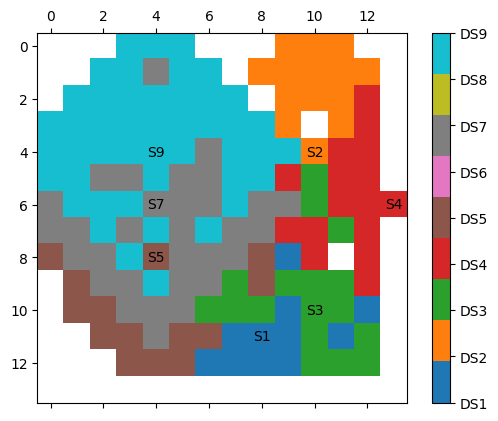

In [ ]:
import matplotlib.pyplot as plt

# Erstellen Sie eine Kopie der Ergebnismatrix, in der die Darkstores und Quadranten durch eindeutige numerische Werte repräsentiert werden
num_matrix = ergebnis_matrix.transpose().copy()
for i in range(14):
    for j in range(14):
        if num_matrix[i, j] is not None:
            if "S" in num_matrix[i, j]:
                num_matrix[i, j] = int(num_matrix[i, j].replace("S", ""))
            else:
                num_matrix[i, j] = int(num_matrix[i, j])

# Ersetzen Sie None-Werte durch einen speziellen numerischen Wert
num_matrix[num_matrix == None] = -1

# Konvertieren Sie die Matrix in eine Matrix von Gleitkommazahlen
num_matrix = num_matrix.astype(float)

# Ersetzen Sie den speziellen numerischen Wert durch NaN
num_matrix[num_matrix == -1] = np.nan

# Erstellen Sie eine Farbkarte, die jedem Darkstore eine eindeutige Farbe zuweist
cmap = plt.get_cmap('tab10', int(np.nanmax(num_matrix) - np.nanmin(num_matrix) + 1))

# Erstellen Sie eine Abbildung und eine Achse
fig, ax = plt.subplots()

# Erstellen Sie die Matrix als Bild
cax = ax.matshow(num_matrix, cmap=cmap)

# Erstellen Sie eine Farblegende
cbar = fig.colorbar(cax, ticks=np.arange(np.nanmin(num_matrix), np.nanmax(num_matrix)+2))  # +2 statt +1
labels = ['DS'+str(i) for i in range(int(np.nanmin(num_matrix)), int(np.nanmax(num_matrix))+2)]  # Beginnen Sie bei DS0
cbar.ax.set_yticklabels(labels[:len(cbar.get_ticks())])  # Stellen Sie sicher, dass die Anzahl der Labels mit der Anzahl der Ticks übereinstimmt

# Zeichnen Sie ein 'X' in die Zellen, die einen Darkstore repräsentieren
for s in S:
    if x[s].solution_value() == 1:
        j,i = Koordinaten[s]['i_Koordinate'], Koordinaten[s]['j_Koordinate']
        if 0 <= i < 14 and 0 <= j < 14:  # Stellen Sie sicher, dass die Koordinaten innerhalb der Matrix liegen
            plt.text(j, i, f'S{str(s)}', ha='center', va='center', color='black')

# Zeigen Sie das Bild an
plt.show()